In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import torch
from torch import nn, optim

In [2]:
from tqdm.notebook import tqdm

In [3]:
import torch.nn.functional as F

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")  

In [6]:
dataset_train = list()


# 1. Train Data Pairs
with open('train_job/train.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):

        if i == 0:
            pass
        else:
            dataset_train.append([line[0], line[1], int(line[2])])

# 2. Job id to number/ Job tags

job_dict = dict()

with open('train_job/job_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
        else:
            try:
                job_dict[line[0]].append(line[1])
            except KeyError:
                job_dict[line[0]] = [line[1]]
                
# 3. Job id to company code and size. Not using right now
                
company_set = set()
jobs_set = set()
company_size_set = set()
job_id_to_com_size_dict = dict()

scales = {'': 0, 
          '1-10': 1, 
          '11-50': 2, 
          '51-100': 3, 
          '101-200': 4, 
          '201-500': 5, 
          '501-1000': 6, 
          '1000 이상': 7}

with open('train_job/job_companies.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
#             print(line)
        else:
            company_set.add(line[0])
            jobs_set.add(line[1])
            company_size_set.add(line[2])
            job_id_to_com_size_dict[line[1]] = scales[line[2]]

# 4. User skills
            
user_dict = dict()

with open('train_job/user_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
    
            try:
                user_dict[line[0]].append(line[1])
            except KeyError:
                user_dict[line[0]] = [line[1]]

# 5. Job required skills
                
tag_dictionary = dict()
tag_idx_to_tag_list = list()

with open('train_job/tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
            tag_dictionary[line[0]] = i - 1
            tag_idx_to_tag_list.append(line)
            assert len(tag_idx_to_tag_list) == i
    
def tagID2Vector(tag_list):
    vector = np.zeros(len(tag_dictionary))
    
    for tag in tag_list:
        vector[tag_dictionary[tag]] = 1
    
    return vector

def jobID2Vector(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

def jobID2CompanyScale(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

In [7]:
for job in job_dict:
    assert len(job_dict[job]) == len(set(job_dict[job]))

In [8]:
def collate_function(data_input):

    global user_dict
    
    person_id_list = list()
    job_id_list = list()
    answer = list()

    for data in data_input:
        person_id_list.append(data[0])
        job_id_list.append(data[1])
        answer.append(data[2])
    
    person_tensor = list()
    for person_id in person_id_list:
        user_skill_set = set(user_dict[person_id])
        vector = tagID2Vector(user_skill_set)
        person_tensor.append(vector)
    person_tensor = torch.tensor(person_tensor)
        
    job_tensor = list()
    for job_id in job_id_list:
        vector = jobID2Vector(job_id)
        job_tensor.append(vector)
    job_tensor = torch.tensor(job_tensor)
        
    answer_tensor = torch.tensor(answer)
      
    com_size_tensor = list()
    for job_id in job_id_list:
        com_size_tensor.append(job_id_to_com_size_dict[job_id])
    com_size_tensor = torch.tensor(com_size_tensor)
    
        
    return person_tensor, job_tensor, answer_tensor, com_size_tensor

In [9]:
dataloader = DataLoader(dataset_train, 
                        batch_size=12, 
                        shuffle=True, 
                        num_workers=4, 
                        collate_fn=collate_function)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.residual_layers = nn.ModuleList([nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                    ])
        
#         self.norm_layers = nn.ModuleList([torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3),
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                     ])
        
        
        
#         self.layers = nn.ModuleList([nn.Linear(887 * 3, 2 ** 11), 
#                                      nn.Linear(2 ** 11, 2 ** 10),
#                                      nn.Linear(2 ** 10, 2 ** 9),
#                                      nn.Linear(2 ** 9, 2 ** 8),
#                                      nn.Linear(2 ** 8, 2 ** 7),
#                                      nn.Linear(2 ** 7, 2 ** 6),
#                                      nn.Linear(2 ** 6, 2 ** 5),
#                                      nn.Linear(2 ** 5, 2 ** 4),
#                                      nn.Linear(2 ** 4, 2 ** 3),
#                                      nn.Linear(2 ** 3, 2 ** 2),
#                                      nn.Linear(2 ** 2, 2 ** 1),
#                                     ])

        self.layers = nn.ModuleList([nn.Linear(887 * 3, 2 ** 11), 
                                     nn.Linear(2 ** 11, 2 ** 10),
                                     nn.Linear(2 ** 10, 2 ** 10),
                                     nn.Linear(2 ** 10, 2 ** 1),
                                    ])
    
        self.dropout = nn.Dropout(p=0.05)
        
        self.pre_layers = nn.ModuleList([nn.Linear(3, 2),
                                        nn.Linear(3, 2),
                                        nn.Linear(3, 2),
                                        nn.Linear(3, 2),
                                        nn.Linear(3, 2),
                                        ])
        
        self.last_layer = nn.Linear(2 ** 1, 2 ** 1)

    def forward(self, tensor, c_tensor=None):
        
        tensor_input = tensor
        
#         for layer, norm_layer in zip(self.residual_layers, self.norm_layers):
        for layer in self.residual_layers:
#             tensor = F.relu(layer(tensor)) + tensor
#             tensor = norm_layer(F.relu(layer(tensor)))
            t_input = tensor
            tensor = F.relu(layer(tensor))
#             tensor = self.dropout(tensor)
            tensor += t_input
            tensor += tensor_input
        
        for layer in self.pre_layers:
            tensor = torch.cat((tensor, c_tensor), 1)
            tensor = F.relu(layer(tensor))
#             tensor = self.dropout(tensor)
#             tensor = layer(tensor)

        for layer in self.layers:
            tensor = F.relu(layer(tensor))
#             tensor = self.dropout(tensor)
#             tensor = layer(tensor)

        
        tensor = self.last_layer(tensor)
        
        tensor = F.softmax(tensor)
        
        return tensor


In [11]:
def accuracy(pred, label):
    
    assert len(pred) == len(label)
    
#     pred_label = np.floor(pred + 0.5)
    
    acc = 0
    
#     print(pred, label)
    
#     for i in range(len(pred)):
#         if pred_label[i] == label[i]:
#             acc += 1

#     return acc / len(pred_label)

    label_pred = [np.argmax(elem) for elem in pred]
    
    for i in range(len(pred)):
        if label_pred[i] == label[i]:
            acc += 1
            
    return acc / len(label_pred)

/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension 

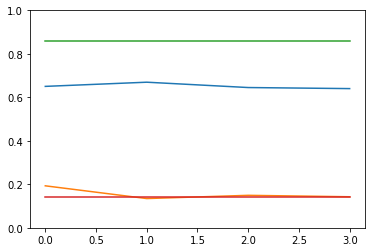

Acc. 0.1549092409240924
Loss 0.6512984525006597


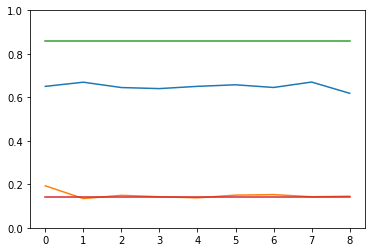

Acc. 0.1457095709570957
Loss 0.6484970390796662


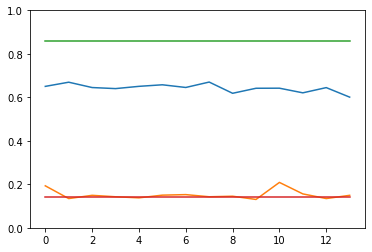

Acc. 0.15577557755775578
Loss 0.6300213643229833


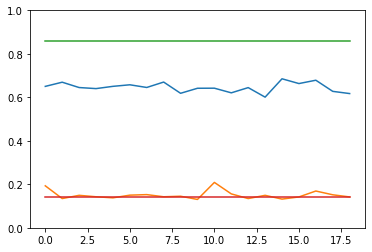

Acc. 0.14735973597359736
Loss 0.6544307756541979


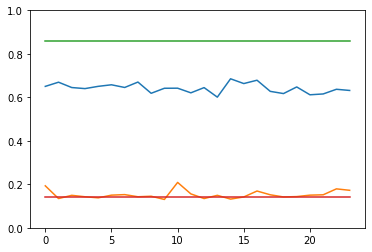

Acc. 0.1594059405940594
Loss 0.628761353469131


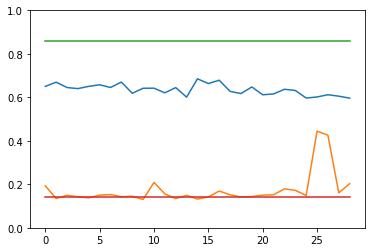

Acc. 0.2765676567656766
Loss 0.6024139779629094


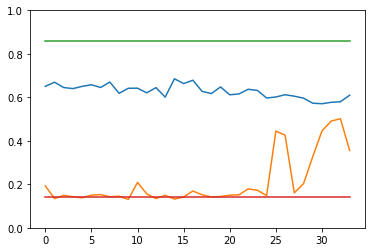

Acc. 0.42425742574257425
Loss 0.5820677916012188


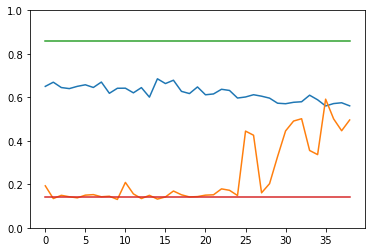

Acc. 0.47425742574257435
Loss 0.5712437258498502


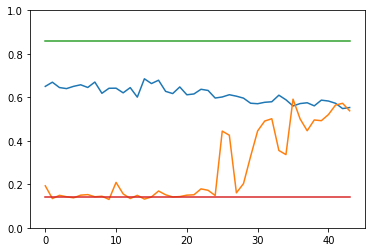

Acc. 0.5376237623762377
Loss 0.568827736141658


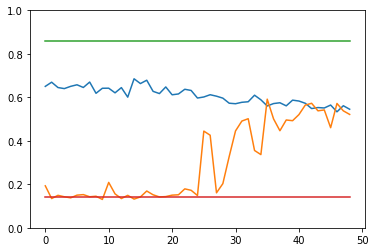

Acc. 0.5267326732673266
Loss 0.5511170095736437


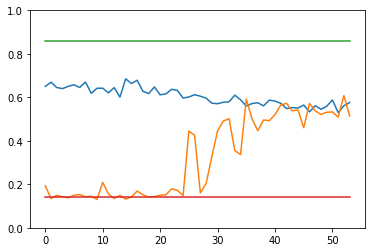

Acc. 0.5391089108910891
Loss 0.5628035055528773


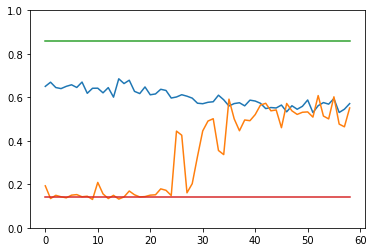

Acc. 0.5191419141914191
Loss 0.5619774917564769


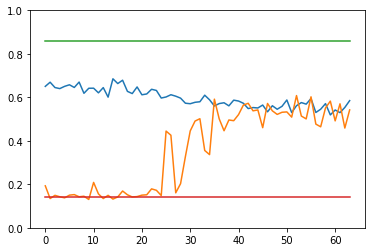

Acc. 0.5290429042904291
Loss 0.5458152323076041


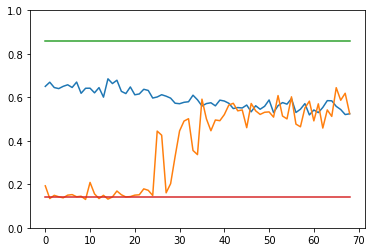

Acc. 0.5773927392739273
Loss 0.5463403717125996


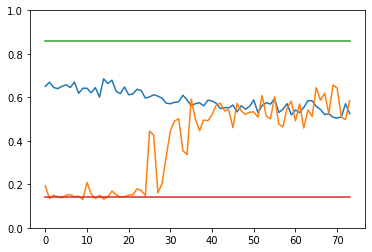

Acc. 0.578052805280528
Loss 0.5235540811968322


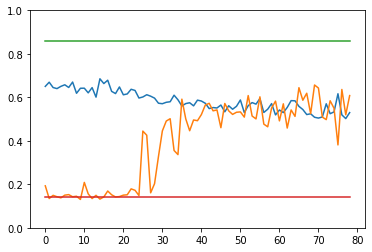

Acc. 0.538943894389439
Loss 0.5402132954337808


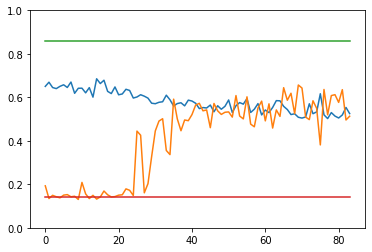

Acc. 0.5666666666666667
Loss 0.5232678991733211


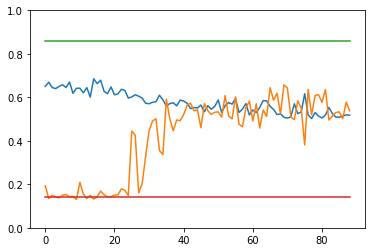

Acc. 0.5363036303630364
Loss 0.5137176769794805


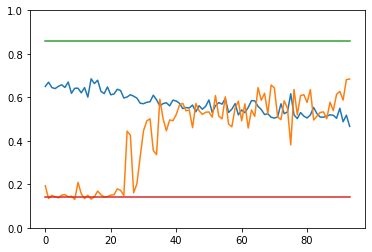

Acc. 0.6387788778877888
Loss 0.5051181106874257


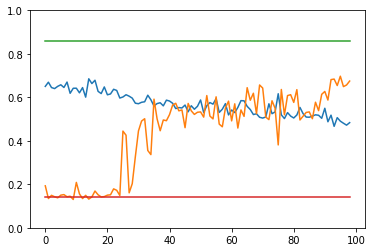

Acc. 0.6665016501650165
Loss 0.48672562117623813


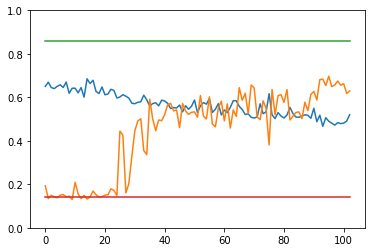

Acc. 0.6481848184818482
Loss 0.4910798824659669


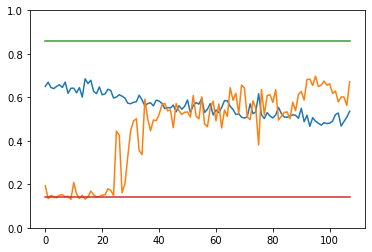

Acc. 0.6033003300330033
Loss 0.5058405139068566


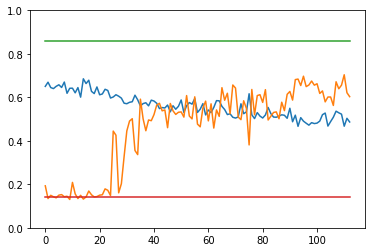

Acc. 0.6447194719471947
Loss 0.5017851735695753


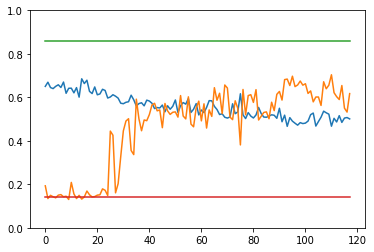

Acc. 0.5887788778877889
Loss 0.5026015893657608


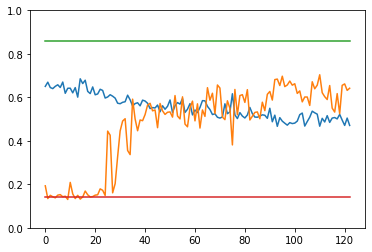

Acc. 0.623102310231023
Loss 0.4926473460575142


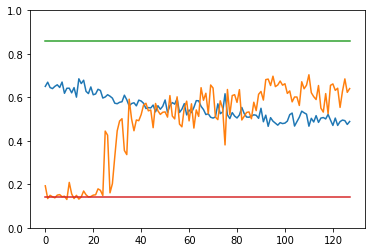

Acc. 0.6259075907590759
Loss 0.48818767454364514


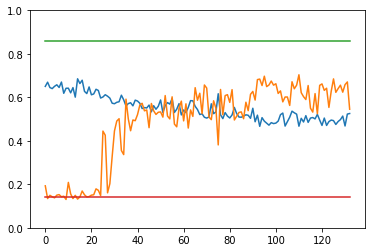

Acc. 0.6308580858085808
Loss 0.5056080360813896


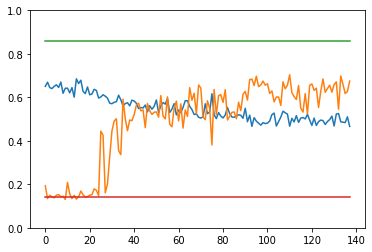

Acc. 0.6552805280528052
Loss 0.4868129330106301


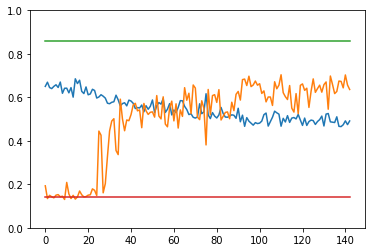

Acc. 0.6625412541254125
Loss 0.4794399060235165


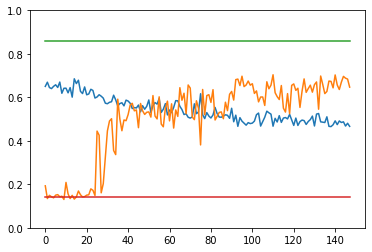

Acc. 0.677062706270627
Loss 0.477372152734511


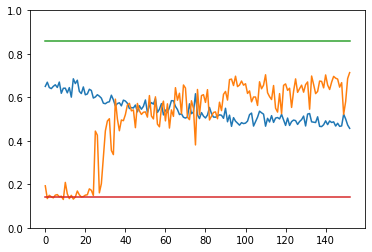

Acc. 0.6339933993399338
Loss 0.4843418037537301


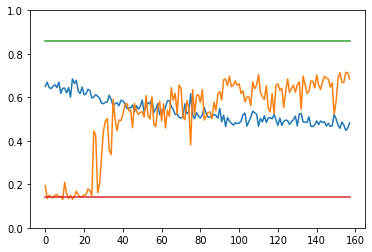

Acc. 0.69009900990099
Loss 0.46951370203849113


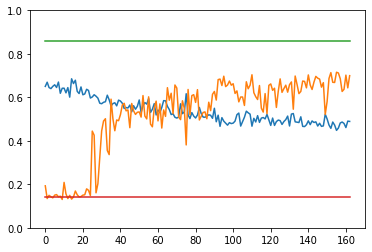

Acc. 0.6618811881188119
Loss 0.4814455245390977


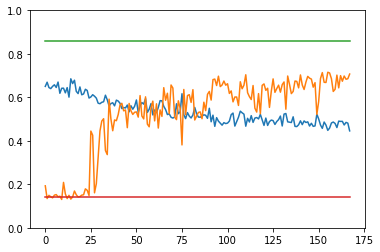

Acc. 0.6896039603960396
Loss 0.47486129863427423


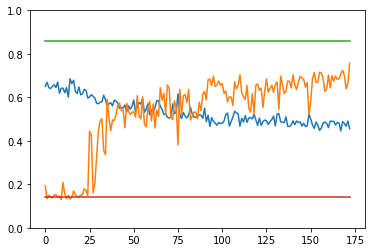

Acc. 0.697029702970297
Loss 0.47644951679919034


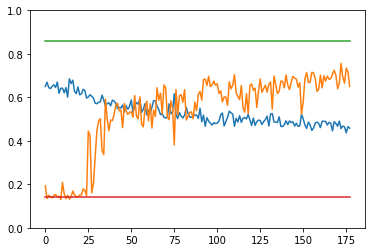

Acc. 0.6922442244224423
Loss 0.45858880045390366


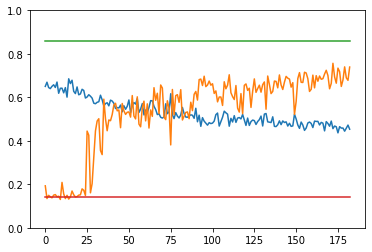

Acc. 0.7054455445544555
Loss 0.45742866290677897


In [ ]:


# 모델 초기화
model = Net().to(device)

# 옵티마이저 초기화
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# weights = [1.0, 6.0]
weights = [1.0, 24.0]
# weights = [1.0, 12.0]

class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

loss_history = list()
acc_history = list()

running_loss = list()
running_acc = list()

for i in range(120):

    for i, (p_tensor, j_tensor, a_tensor, c_tensor) in tqdm(enumerate(dataloader)):

    #     print(i)
    #     print(p_tensor.shape)
    #     print(j_tensor.shape)
    #     print(a_tensor.shape)

        p_tensor = torch.tensor(p_tensor, dtype=torch.float32)
        j_tensor = torch.tensor(j_tensor, dtype=torch.float32)
        c_tensor = torch.tensor(c_tensor, dtype=torch.float32)
        a_tensor = torch.tensor(a_tensor, dtype=torch.int64)

        s_tensor = torch.clamp(j_tensor - p_tensor, 0, 1)

        input_tensor = torch.cat((p_tensor, j_tensor, s_tensor), 1)

        model.zero_grad()

        pred_tensor = model(input_tensor.to(device), c_tensor.to(device))

    #     pred_tensor = torch.tensor(pred_tensor, dtype=torch.float64)

    #     print(pred_tensor.dtype)
    #     print(a_tensor.dtype)

        loss = criterion(pred_tensor, a_tensor.to(device))
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_acc.append(accuracy(pred_tensor.cpu().detach().numpy(), 
                           a_tensor.cpu().detach().numpy()))
        
        if len(running_loss) > 100:
            loss_history.append(np.mean(running_loss))
            acc_history.append(np.mean(running_acc))
            running_loss = list()
            running_acc = list()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.plot([0.8571] * len(acc_history))
    plt.plot([0.1428] * len(acc_history))
    plt.ylim([0, 1])
    plt.show()
    
    print(f'Acc. {np.mean(acc_history[-5:])}')
    print(f'Loss {np.mean(loss_history[-5:])}')